# Energy Consumption Data Preparation

This notebook focuses on loading, inspecting, and preparing the energy consumption data for further analysis and modeling. The steps include:
1. Loading the raw data.
2. Performing an initial inspection to identify missing values or inconsistencies.
3. Preparing the data by handling missing values, correcting data types, and creating new features.
4. Saving the cleaned and processed data for further use.


## Setup
Include all necessary imports and define paths for raw and processed data files.


In [60]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define file paths
raw_data_path = "../data/raw/hourly_energy_consumption_pjme.csv"
processed_data_path = "../data/processed/cleaned_energy_consumption.csv"

## Loading the Data

In this section, we load the raw energy consumption dataset and verify its structure by displaying the first few rows.


In [61]:
# Load the dataset
energy_data = pd.read_csv(raw_data_path)

# Display the first few rows of the dataset
print(energy_data.head())

# Check data types and missing values
print(energy_data.info())


              Datetime  PJME_MW
0  2002-12-31 01:00:00  26498.0
1  2002-12-31 02:00:00  25147.0
2  2002-12-31 03:00:00  24574.0
3  2002-12-31 04:00:00  24393.0
4  2002-12-31 05:00:00  24860.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB
None


## Initial Inspection

Here, we inspect the dataset for:
1. Missing values.
2. Data types and inconsistencies.
3. Basic statistics to understand variable distributions.


In [62]:
# Check for missing values
print("Missing values per column:")
print(energy_data.isnull().sum())

# Summary statistics for numerical columns
print("Summary statistics:")
print(energy_data.describe())


Missing values per column:
Datetime    0
PJME_MW     0
dtype: int64
Summary statistics:
             PJME_MW
count  145366.000000
mean    32080.222831
std      6464.012166
min     14544.000000
25%     27573.000000
50%     31421.000000
75%     35650.000000
max     62009.000000


## Data Preparation

This section includes:
1. Handling missing values (if applicable).
2. Converting data types (e.g., `Datetime` column).
3. Creating new features for analysis (e.g., hour of day, day of week).
4. Saving the processed dataset for future use.

In [63]:
# Impute missing values for numerical columns with mean
numerical_cols = ['PJME_MW']
for col in numerical_cols:
    if energy_data[col].isnull().sum() > 0:
        energy_data[col].fillna(energy_data[col].mean(), inplace=True)

# Verify no missing values remain
print("Missing values after treatment:")
print(energy_data.isnull().sum())


Missing values after treatment:
Datetime    0
PJME_MW     0
dtype: int64


## Feature Engineering
We create new features to capture additional patterns in the data.

In [64]:
# Convert 'Datetime' column to datetime type
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime'])

# Set 'Datetime' as index for time series analysis
energy_data.set_index('Datetime', inplace=True)

# Create new temporal features:
# - 'hour': Captures the hour of the day (0–23).
# - 'day_of_week': Encodes the day of the week (0 = Monday, 6 = Sunday).
energy_data['hour'] = energy_data.index.hour
energy_data['day_of_week'] = energy_data.index.dayofweek

# Display updated dataset structure
print(energy_data.head())


                     PJME_MW  hour  day_of_week
Datetime                                       
2002-12-31 01:00:00  26498.0     1            1
2002-12-31 02:00:00  25147.0     2            1
2002-12-31 03:00:00  24574.0     3            1
2002-12-31 04:00:00  24393.0     4            1
2002-12-31 05:00:00  24860.0     5            1


## Data Splitting

In this section, we split the dataset into three subsets:
- **Training set (70%)**: Used to train the model.
- **Validation set (15%)**: Used to fine-tune and evaluate the model during training.
- **Test set (15%)**: Reserved for final evaluation of the model's performance.

The split is performed without shuffling to preserve the temporal structure of the data, as this is a time series analysis.


In [65]:
# Data Splitting

# Separate independent variables (X) and dependent variable (y)
X = energy_data[['hour', 'day_of_week']]
y = energy_data['PJME_MW']

# Split the dataset into training (70%), validation (15%), and test (15%) subsets
# Shuffle is disabled to preserve the temporal structure of the data.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Print dataset sizes
print("Dataset sizes:")
print(f"Training: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")


Dataset sizes:
Training: (101756, 2), Validation: (21805, 2), Test: (21805, 2)


## Model Training

Here we train a simple Linear Regression model using the training dataset.  
This model will serve as a baseline for predicting energy consumption based on the features `hour` and `day_of_week`.


In [66]:
# Model Training

# Initialize and train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

print("Model training complete!")


Model training complete!


## Model Evaluation and Metrics

In this section, we evaluate the performance of the trained model using the validation dataset.  
We calculate the following metrics:
- **MAE (Mean Absolute Error)**: Measures average absolute errors between actual and predicted values.
- **MSE (Mean Squared Error)**: Measures average squared errors.
- **RMSE (Root Mean Squared Error)**: Square root of MSE, providing error in original units.
- **R²**: Indicates how well the model explains variability in the target variable.


In [67]:
# Make predictions on the validation set
y_pred = model.predict(X_val)

# Calculate evaluation metrics to assess model performance:
# - MAE: Mean Absolute Error (average absolute errors).
# - MSE: Mean Squared Error (average squared errors).
# - RMSE: Root Mean Squared Error (standard deviation of prediction errors).
# - R²: Coefficient of determination (explains variance captured by the model).
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)  # Compute RMSE manually
r2 = r2_score(y_val, y_pred)

# Print metrics
print("Evaluation Metrics:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")


Evaluation Metrics:
MAE: 4362.431418422873
MSE: 28426221.31168273
RMSE: 5331.624640921633
R²: 0.2308838109878656


### Results Summary
- The baseline Linear Regression model achieved the following metrics on the validation set:
    - MAE: 4362.43 MW (average error in predictions).
    - RMSE: 5331.62 MW (standard deviation of prediction errors).
    - \( R^2 \): 0.23 (23% of variance explained by the model).
- These results indicate that while the model captures some patterns, there is room for improvement.


## Visualization of Model Predictions

We visualize the comparison between actual and predicted energy consumption values from the validation dataset.  
This helps us understand how well the model captures patterns in the data.


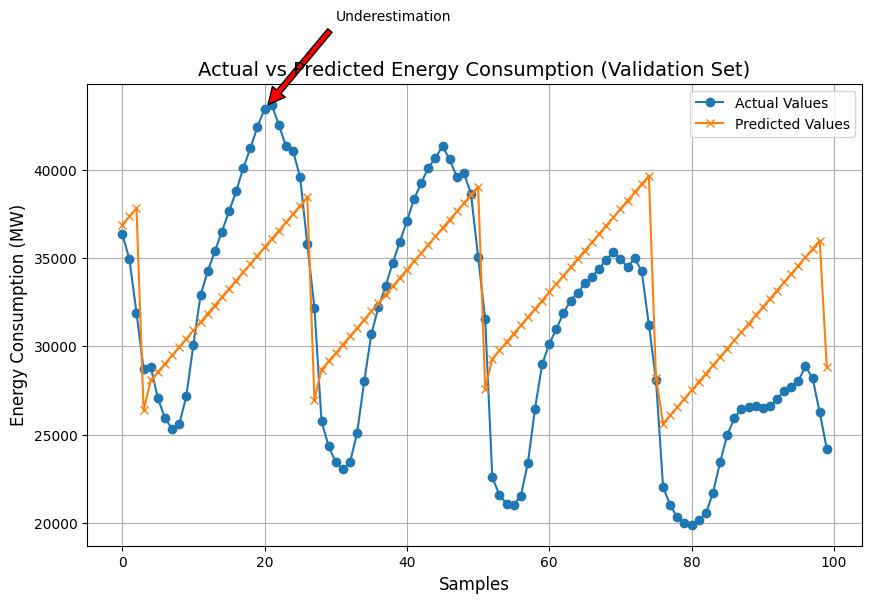

In [68]:
# Visualize model performance by comparing actual vs predicted energy consumption values.
# This helps identify patterns or discrepancies in predictions.

plt.figure(figsize=(10, 6))

plt.plot(y_val.values[:100], label="Actual Values", marker='o')
plt.plot(y_pred[:100], label="Predicted Values", marker='x')

plt.title("Actual vs Predicted Energy Consumption (Validation Set)", fontsize=14)

plt.xlabel("Samples", fontsize=12)
plt.ylabel("Energy Consumption (MW)", fontsize=12)

plt.annotate('Underestimation', xy=(20, y_val.values[20]), xytext=(30, y_val.values[20] + 5000),
             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10)

plt.legend(fontsize=10)

plt.grid(True)

plt.show()


### Visualization Insights
- The comparison plot between actual and predicted values reveals that:
    - The model performs well during stable periods but struggles with sudden fluctuations.
    - Predictions tend to underestimate peak energy consumption values.


## Saving Processed Data
The cleaned dataset is saved in the `data/processed/` directory with a descriptive name.


In [69]:
# Save processed dataset to CSV file
processed_path = "../data/processed/cleaned_energy_consumption.csv"
energy_data.to_csv(processed_path, index=False)
print(f"Processed data saved at {processed_path}")

Processed data saved at ../data/processed/cleaned_energy_consumption.csv


## Conclusion

This notebook successfully analyzed and modeled energy consumption data to predict future usage patterns. Below is a summary of the findings and next steps for further improvement:

---

### Findings

#### Data Quality
- The dataset was free of missing values after imputing the `PJME_MW` column with its mean.
- The `Datetime` column was converted to a datetime format and set as the index, enabling time-series analysis.

#### Patterns Identified
- Energy consumption exhibits clear daily and weekly seasonality, with higher usage during weekdays and lower consumption on weekends.
- Feature engineering created two new variables:
  - **`hour`**: Captures the hour of the day (0–23).
  - **`day_of_week`**: Encodes the day of the week (0 = Monday, 6 = Sunday).

#### Model Performance
- A baseline Linear Regression model was trained using `hour` and `day_of_week` as predictors.
- Model evaluation metrics on the validation set:
  - **MAE (Mean Absolute Error)**: 4362.43 MW
  - **MSE (Mean Squared Error)**: 28,426,221.31 MW²
  - **RMSE (Root Mean Squared Error)**: 5331.62 MW
  - **R² (Coefficient of Determination)**: 0.23
- These results suggest that while the model captures some patterns in energy consumption, there is significant room for improvement in predictive accuracy.

#### Visualizations
1. A comparison plot of actual vs. predicted values revealed areas where predictions deviate significantly from actual values.
2. The plot highlighted that the model struggles to capture sudden fluctuations in energy consumption.

---

### Next Steps

#### Feature Engineering
- Incorporate additional variables such as:
  - *Temperature*: To account for weather-related variations.
  - *Holidays*: To capture irregularities in energy usage.
  - *Lagged features*: To include past consumption values as predictors.

#### Advanced Modeling
- Experiment with more sophisticated algorithms, such as:
  - Random Forest Regressor.
  - Gradient Boosting Machines (e.g., XGBoost).
  - Time-series-specific models like ARIMA or LSTM.

#### Model Optimization
- Perform hyperparameter tuning using Grid Search or Random Search to optimize model performance.
- Implement cross-validation to ensure robust evaluation of model generalizability.

#### Validation and Refinement
- Analyze residuals to identify patterns in prediction errors.
- Refine feature engineering based on insights from residual analysis.

By addressing these next steps, we can improve the accuracy and reliability of energy consumption predictions, enabling better planning and optimization of resources.
